In [2]:
import os
import glob
import pickle
import tensorflow as tf    # used for creating tensors out of the dataset and training the model
import tensorflow_hub as hub    # downloading and using pre-trained 0models
import numpy as np
import h5py   # to manipulate the dataset as it's in `.h5` format
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report   # essential for model's evaluation
from sklearn.metrics import f1_score
from tqdm import tqdm   # getting a progress bar for an iterable object
import random

In [3]:
test_dir = "C:/Users/Ananya Doshi/OneDrive/Documents/BE_PROJECT_DJSCE/TextileDefect_OwnDataset/own_dataset/test - Copy"
train_dir = "C:/Users/Ananya Doshi/OneDrive/Documents/BE_PROJECT_DJSCE/TextileDefect_OwnDataset/own_dataset/train - Copy"

In [4]:
# train and test data pipelines created to load and preprocess images from the train and test directories respectively
# The dataset is then prefetched and cached for optimized performance.
# the ratio of train and test data split is 3:1
# train - 1080000 images and test - 36000 images


# create train data pipeline
IMG_SIZE = (64, 64) # define image size
train_data = tf.keras.utils.image_dataset_from_directory(directory=train_dir,
                                                         image_size=IMG_SIZE,
                                                         color_mode="grayscale",
                                                         label_mode="int", #  label type is encoding of the form `[1, 2, 3, ...]`
                                                         batch_size=len(os.listdir("C:/Users/Ananya Doshi/OneDrive/Documents/BE_PROJECT_DJSCE/TextileDefect_OwnDataset/own_dataset/train - Copy/good")) + len(os.listdir("C:/Users/Ananya Doshi/OneDrive/Documents/BE_PROJECT_DJSCE/TextileDefect_OwnDataset/own_dataset/train - Copy/damaged")))
                                                        # Batch size is set to be the size of the whole dataset to make loading data into x_train, y_train easier.
class_names = train_data.class_names
print(f"The class_names are as follows: {class_names}")

train_data = train_data.prefetch(buffer_size=tf.data.AUTOTUNE).\
                        cache()

# create test data pipeline
test_data = tf.keras.utils.image_dataset_from_directory(directory=test_dir,
                                                        image_size=IMG_SIZE,
                                                        color_mode="grayscale",
                                                        shuffle=False,
                                                        batch_size=len(os.listdir("C:/Users/Ananya Doshi/OneDrive/Documents/BE_PROJECT_DJSCE/TextileDefect_OwnDataset/own_dataset/test - Copy/good")) + len(os.listdir("C:/Users/Ananya Doshi/OneDrive/Documents/BE_PROJECT_DJSCE/TextileDefect_OwnDataset/own_dataset/test - Copy/damaged")),
                                                        label_mode="int")

test_data = test_data.prefetch(buffer_size=tf.data.AUTOTUNE).\
                      cache()

Found 2277 files belonging to 2 classes.
The class_names are as follows: ['damaged', 'good']
Found 72 files belonging to 2 classes.


In [5]:
# check the proportions of classes
damaged_counts = 0
for _ in os.listdir(f"C:/Users/Ananya Doshi/OneDrive/Documents/BE_PROJECT_DJSCE/TextileDefect_OwnDataset/own_dataset/train - Copy/damaged"):
  damaged_counts += 1

good_counts = 0
for _ in os.listdir(f"C:/Users/Ananya Doshi/OneDrive/Documents/BE_PROJECT_DJSCE/TextileDefect_OwnDataset/own_dataset/train - Copy/good"):
  good_counts += 1

total = damaged_counts + good_counts

new_train_df64 = pd.Series({"damaged": damaged_counts/total,
                            "good": good_counts/total}).round(2)
new_train_df64

damaged    0.85
good       0.15
dtype: float64

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create an ImageDataGenerator instance with desired augmentation parameters
datagen = ImageDataGenerator(
    rotation_range=20,  # rotate images randomly up to 20 degrees
    width_shift_range=0.2,  # shift images horizontally by up to 20% of the width
    height_shift_range=0.2,  # shift images vertically by up to 20% of the height
    shear_range=0.2,  # shear transformations
    zoom_range=0.2,  # zoom inside the image
    horizontal_flip=True,  # flip images horizontally
    vertical_flip=True,  # flip images vertically
    fill_mode='nearest'  # method for filling in newly created pixels
)

# Generate augmented data for the 'good' class
good_dir = "C:/Users/Ananya Doshi/OneDrive/Documents/BE_PROJECT_DJSCE/TextileDefect_OwnDataset/own_dataset/train - Copy/good"
augmented_data = []
for image_path in os.listdir(good_dir):
    image = tf.keras.preprocessing.image.load_img(os.path.join(good_dir, image_path), grayscale=True)
    image = tf.keras.preprocessing.image.img_to_array(image)
    image = image.reshape((1,) + image.shape)  # reshape to (1, height, width, channels) as required by flow method
    i = 0
    for batch in datagen.flow(image, batch_size=1):
        augmented_data.append(batch[0])
        i += 1
        if i >= 5:  # augment each image 5 times
            break

# Convert the augmented data to numpy array
augmented_data = np.array(augmented_data)

# Now, you can use this augmented_data along with the original data to train your model


c:\Users\Ananya Doshi\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\utils\image_utils.py:409: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn(


(array([0, 1]), [Text(0, 0, 'damaged'), Text(1, 0, 'good')])

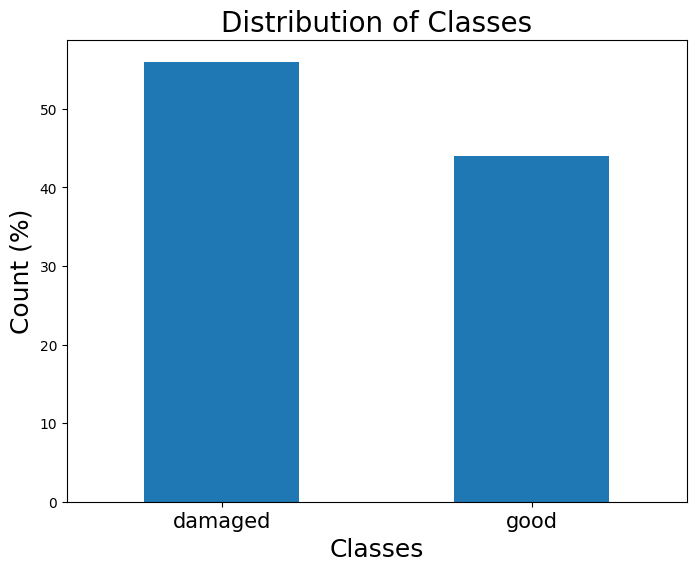

In [8]:
# check the classes distribution
(new_train_df64*100).to_frame().plot.bar(legend=False, figsize=(8, 6))
plt.xlabel('Classes', fontsize=18)
plt.ylabel("Count (%)", fontsize=18)
plt.title("Distribution of Classes", fontsize=20)
plt.xticks(rotation=0, fontsize=15)

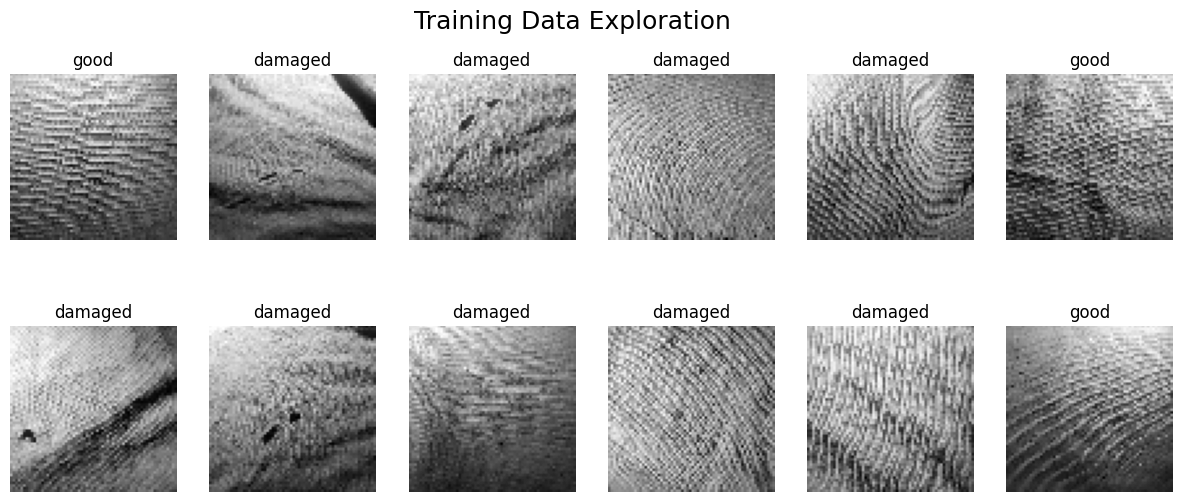

In [6]:
# explore the train data
def explore_data(n_rows, n_cols, figsize):
    count = 0
    fig, axs = plt.subplots(n_rows, n_cols, figsize=figsize) # plot 20 figures
    fig.suptitle("Training Data Exploration", fontsize=18, y=0.95)
    for data, ax in zip(train_data.shuffle(10000).take(1).unbatch(), axs.ravel()):
        img, label = data

        ax.axis("off")
        ax.set_title(f"{class_names[label]}")
        ax.imshow(np.squeeze(img), cmap="gray")

        count+=1
        if count == n_rows*n_cols:
          break

explore_data(n_rows=2, n_cols=6, figsize=(15, 6))

In [7]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

In [8]:
IMG_SIZE = (64, 64)
BATCH_SIZE = 32  # Adjust the batch size as needed

In [9]:
# Limit GPU memory growth
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

In [10]:
datagen = ImageDataGenerator(rescale=1./255, horizontal_flip=True, vertical_flip=True)

In [11]:
train_data = datagen.flow_from_directory(
    directory=train_dir,
    target_size=IMG_SIZE,
    color_mode="grayscale",
    batch_size=BATCH_SIZE,
    class_mode="input",  # Assuming the images are grayscale and you want to reconstruct them
    shuffle=True
)

Found 2277 images belonging to 2 classes.


In [52]:
# Build the autoencoder model
encoder = models.Sequential([
    layers.Input(shape=(64,64, 1)),
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    # layers.Conv2D(32, (3, 3), activation='relu', padding='same', weights=models.layers[1].get_weights(), strides=(1, 1)),
    layers.MaxPooling2D((2, 2), padding='same'),
    layers.Conv2D(16, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2), padding='same'),
    layers.Conv2D(8, (3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D((2, 2), padding='same'),
])

decoder = models.Sequential([
    layers.Conv2D(8, (3, 3), activation='relu', padding='same'),
    layers.UpSampling2D((2, 2)),
    layers.Conv2D(16, (3, 3), activation='relu', padding='same'),
    layers.UpSampling2D((2, 2)),
    layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    layers.UpSampling2D((2, 2)),
    layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same'),
])

In [13]:
encoder.compile(optimizer='adam', loss='mse')
decoder.compile(optimizer='adam', loss='mse')

In [14]:
autoencoder = models.Sequential([
    encoder,
    decoder,
])

In [15]:
autoencoder.compile(optimizer='adam', loss='mse')

In [16]:
autoencoder.build((None, *IMG_SIZE, 1))  # Explicitly build the model with a sample input
autoencoder.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 8, 8, 8)           6104      
                                                                 
 sequential_1 (Sequential)   (None, 64, 64, 1)         6681      
                                                                 
Total params: 12785 (49.94 KB)
Trainable params: 12785 (49.94 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [17]:
autoencoder.fit(train_data, epochs=10, verbose=1, steps_per_epoch=len(train_data))

Epoch 1/10
72/72 [==============================] - 84s 1s/step - loss: 0.0244
Epoch 2/10
72/72 [==============================] - 74s 1s/step - loss: 0.0126
Epoch 3/10
72/72 [==============================] - 71s 980ms/step - loss: 0.0118
Epoch 4/10
72/72 [==============================] - 69s 963ms/step - loss: 0.0114
Epoch 5/10
72/72 [==============================] - 68s 946ms/step - loss: 0.0112
Epoch 6/10
72/72 [==============================] - 80s 1s/step - loss: 0.0111
Epoch 7/10
72/72 [==============================] - 75s 1s/step - loss: 0.0110
Epoch 8/10
72/72 [==============================] - 75s 1s/step - loss: 0.0110
Epoch 9/10
72/72 [==============================] - 74s 1s/step - loss: 0.0109
Epoch 10/10
72/72 [==============================] - 68s 946ms/step - loss: 0.0108


In [18]:
autoencoder.save("C:/Users/Ananya Doshi/OneDrive/Documents/BE_PROJECT_DJSCE/TextileDefect_OwnDataset/autoencoder_model.h5")
# Optionally, you can save only the encoder or decoder
encoder.save("C:/Users/Ananya Doshi/OneDrive/Documents/BE_PROJECT_DJSCE/TextileDefect_OwnDataset/encoder_model.h5")
decoder.save("C:/Users/Ananya Doshi/OneDrive/Documents/BE_PROJECT_DJSCE/TextileDefect_OwnDataset/decoder_model.h5")

c:\Users\Ananya Doshi\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [14]:
from tensorflow.keras.models import load_model

In [16]:
autoencoder=load_model('C:/Users/Ananya Doshi/OneDrive/Documents/BE_PROJECT_DJSCE/TextileDefect/autoencoder_model.h5')

In [17]:
encoder=load_model('C:/Users/Ananya Doshi/OneDrive/Documents/BE_PROJECT_DJSCE/TextileDefect/encoder_model.h5')
decoder=load_model('C:/Users/Ananya Doshi/OneDrive/Documents/BE_PROJECT_DJSCE/TextileDefect/decoder_model.h5')

1/1 [==============================] - 0s 65ms/step


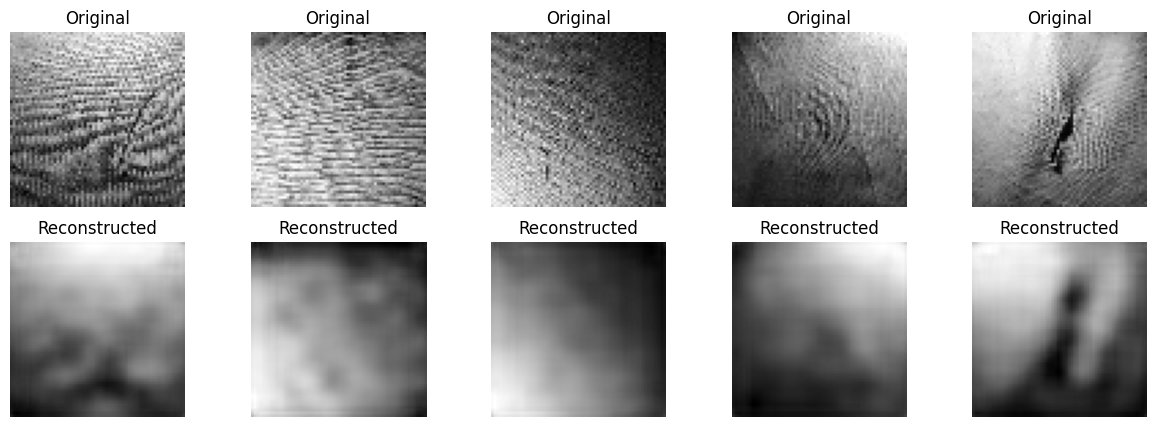

In [23]:
import matplotlib.pyplot as plt

# Function to plot original and reconstructed images
def plot_images(original_images, reconstructed_images, num_samples=5):
    fig, axes = plt.subplots(2, num_samples, figsize=(15, 5))

    for i in range(num_samples):
        # Plot original image
        axes[0, i].imshow(original_images[i, :, :, 0], cmap='gray')
        axes[0, i].set_title("Original")
        axes[0, i].axis('off')

        # Plot reconstructed image
        axes[1, i].imshow(reconstructed_images[i, :, :, 0], cmap='gray')
        axes[1, i].set_title("Reconstructed")
        axes[1, i].axis('off')

    plt.show()

# Extract a batch of original images from the generator
original_images, _ = next(iter(train_data))

# Use the trained autoencoder to reconstruct images
reconstructed_images = autoencoder.predict(original_images)

# Plot original and reconstructed images
plot_images(original_images, reconstructed_images)


In [24]:

import matplotlib.pyplot as plt
import os

# Function to save reconstructed images
def save_reconstructed_images(reconstructed_images, save_path="saved_images"):
    # Create the directory if it does not exist
    if not os.path.exists(save_path):
        os.makedirs(save_path)
        
    for i, reconstructed_image in enumerate(reconstructed_images):
        fig, ax = plt.subplots(figsize=(4, 4))  # Adjust the size as needed

        # Plot reconstructed image without title, white border, and axis
        ax.imshow(reconstructed_image[:, :, 0], cmap='gray')
        ax.axis('off')

        # Save the figure without title, white border, and axis
        plt.savefig(os.path.join(save_path, f'reconstructed_image_{i + 1}.png'), bbox_inches='tight', pad_inches=0)
        plt.close()
# ****************************************************
def save_original_images(original_images, save_path="saved_images"):
    # Create the directory if it does not exist
    if not os.path.exists(save_path):
        os.makedirs(save_path)
        
    for i, original_image in enumerate(original_images):
        fig, ax = plt.subplots(figsize=(4, 4))  # Adjust the size as needed

        # Plot reconstructed image without title, white border, and axis
        ax.imshow(original_image[:, :, 0], cmap='gray')
        ax.axis('off')

        # Save the figure without title, white border, and axis
        plt.savefig(os.path.join(save_path, f'original_image_{i + 1}.png'), bbox_inches='tight', pad_inches=0)
        plt.close()

# Extract a batch of original images from the generator
original_images, _ = next(iter(train_data))

# Use the trained autoencoder to reconstruct images
reconstructed_images = autoencoder.predict(original_images)

# Specify the directory to save the images
save_directory = "C:/Users/Ananya Doshi/OneDrive/Documents/BE_PROJECT_DJSCE/TextileDefect_OwnDataset/reconstruceted_images"
save_original = "C:/Users/Ananya Doshi/OneDrive/Documents/BE_PROJECT_DJSCE/TextileDefect_OwnDataset/original_images"
# Save the reconstructed images without plotting
save_reconstructed_images(reconstructed_images, save_path=save_directory)
save_original_images(original_images, save_path=save_original)

1/1 [==============================] - 0s 76ms/step


In [25]:
test_data = datagen.flow_from_directory(
    directory=test_dir,
    target_size=IMG_SIZE,
    color_mode="grayscale",
    batch_size=BATCH_SIZE,
    class_mode="input",  # Assuming the images are grayscale and you want to reconstruct them
    shuffle=True
)

Found 72 images belonging to 2 classes.


1/1 [==============================] - 0s 125ms/step


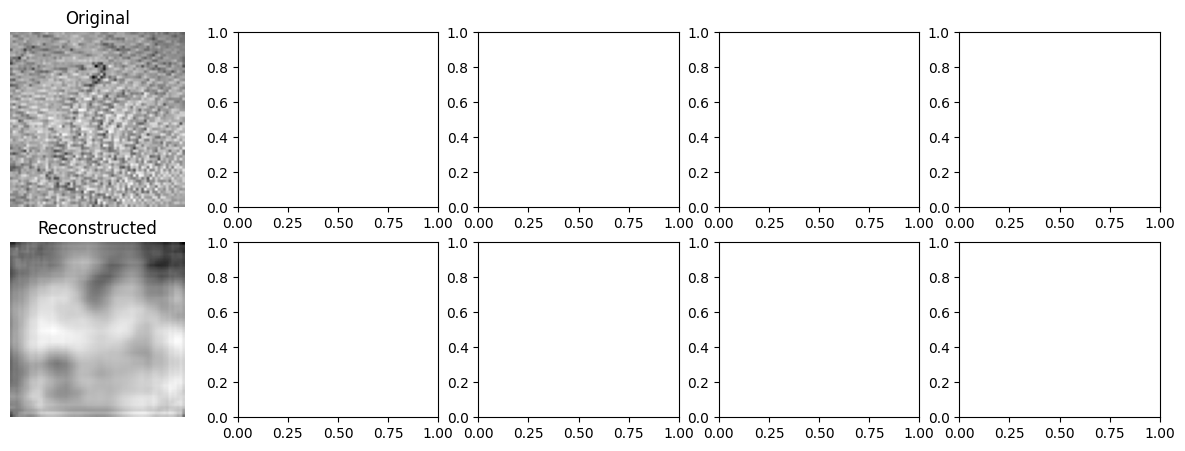

In [26]:
import matplotlib.pyplot as plt

# Function to plot original and reconstructed images
def plot_images(original_images, reconstructed_images, num_samples=5):
    fig, axes = plt.subplots(2, num_samples, figsize=(15, 5))

    for i in range(1):
        # Plot original image
        axes[0, i].imshow(original_images[i, :, :, 0], cmap='gray')
        axes[0, i].set_title("Original")
        axes[0, i].axis('off')

        # Plot reconstructed image
        axes[1, i].imshow(reconstructed_images[i, :, :, 0], cmap='gray')
        axes[1, i].set_title("Reconstructed")
        axes[1, i].axis('off')
        # Save the figure
        plt.savefig('reconstructed_images.png')  # Change the filename as needed
    

    plt.show()

# Extract a batch of original images from the generator
original_images, _ = next(iter(test_data))

# Use the trained autoencoder to reconstruct images
reconstructed_images = autoencoder.predict(original_images)


# Plot original and reconstructed images
plot_images(original_images, reconstructed_images)


In [27]:
# encoder = models.Sequential([
#     layers.Input(shape=(*IMG_SIZE, 1)),
#     layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
#     layers.MaxPooling2D((2, 2), padding='same'),
#     layers.Conv2D(16, (3, 3), activation='relu', padding='same'),
#     layers.MaxPooling2D((2, 2), padding='same'),
#     layers.Conv2D(8, (3, 3), activation='relu', padding='same'),
#     layers.MaxPooling2D((2, 2), padding='same'),
# ])
encoder_layers = autoencoder.layers[0].layers

# Set the weights for each layer in the encoder
encoder.layers[1].set_weights(encoder_layers[1].get_weights())
encoder.layers[3].set_weights(encoder_layers[3].get_weights())
encoder.layers[5].set_weights(encoder_layers[5].get_weights())

# Print the summary of the encoder
encoder.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 16)        4624      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 16, 16, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 8)         1160      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 8, 8, 8)           0

In [28]:
########################################################
# Calculate KDE using sklearn
from sklearn.neighbors import KernelDensity
from PIL import Image

#Get encoded output of input images = Latent space
encoded_images = encoder.predict_generator(train_data)

# Flatten the encoder output because KDE from sklearn takes 1D vectors as input
encoder_output_shape = encoder.output_shape #Here, we have 16x16x16
out_vector_shape = encoder_output_shape[1]*encoder_output_shape[2]*encoder_output_shape[3]

encoded_images_vector = [np.reshape(img, (out_vector_shape)) for img in encoded_images]

#Fit KDE to the image latent data
kde = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(encoded_images_vector)


C:\RProgramming\ipykernel_8416\2260331772.py:7: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  encoded_images = encoder.predict_generator(train_data)


In [29]:

#Calculate density and reconstruction error to find their means values for
#good and anomaly images.
#We use these mean and sigma to set thresholds.
def calc_density_and_recon_error(batch_images):
    density_list = []
    recon_error_list = []
    for im in range(0, batch_images.shape[0] - 1):
        img = batch_images[im]
        img = img[np.newaxis, :, :, :]
        encoded_img = encoder.predict([[img]])  # Create a compressed version of the image using the encoder
        encoded_img = [np.reshape(img, (out_vector_shape)) for img in encoded_img]  # Flatten the compressed image
        density = kde.score_samples(encoded_img)[0]  # get a density score for the new image
        reconstruction = autoencoder.predict([[img]])
        reconstruction_error = autoencoder.evaluate([reconstruction], [[img]], batch_size=1)  # Note the removal of [0]
        density_list.append(density)
        recon_error_list.append(reconstruction_error)

    average_density = np.mean(np.array(density_list))
    stdev_density = np.std(np.array(density_list))

    average_recon_error = np.mean(np.array(recon_error_list))
    stdev_recon_error = np.std(np.array(recon_error_list))
    print(average_density)
    print(average_recon_error)

    return average_density, stdev_density, average_recon_error, stdev_recon_error

In [30]:

#Get average and std dev. of density and recon. error for uninfected and anomaly (parasited) images.
#For this let us generate a batch of images for each.
train_batch = train_data.next()[0]
anomaly_batch = test_data.next()[0]

uninfected_values = calc_density_and_recon_error(train_batch)
anomaly_values = calc_density_and_recon_error(anomaly_batch)

1/1 [==============================] - 0s 49ms/step - loss: 0.0049
339.6410951811787
0.010048121811010904
1/1 [==============================] - 0s 49ms/step - loss: 0.0149
328.02881868690946
0.012898294119945457


In [53]:
# import numpy as np
# from tensorflow.keras.preprocessing import image
# #Now, input unknown images and sort as Good or Anomaly
# def check_anomaly(img_path):
#     density_threshold = 310  # Set this value based on the above exercise
#     reconstruction_error_threshold = 0.004  # Set this value based on the above exercise
#     img = Image.open(img_path)
#     img = np.array(img.resize(IMG_SIZE, Image.ANTIALIAS))
#     plt.imshow(img)

#     # img = img / 255.
#     # img = img[np.newaxis, :, :, :]
# # ************************************************************
#     img_path = img_path  # Replace with the actual path to your image
#     img = image.load_img(img_path, target_size=IMG_SIZE, color_mode="grayscale")
#     img_array = image.img_to_array(img)
#     img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
#     img_array /= 255.0  # Normalize the pixel values to the range [0, 1]
# # *****************************************************************
#     encoded_img = encoder.predict([[img_array]])
#     encoded_img = [np.reshape(img, (out_vector_shape)) for img in encoded_img]
#     density = kde.score_samples(encoded_img)[0]
# # *********************************************************************
#     # imgs = Image.open(encoded_img)
#     # imgs = np.array(imgs.resize(IMG_SIZE, Image.ANTIALIAS))
#     # plt.imshow(imgs)
# # *********************************************************************

#     print("The density calculated is: ",density)
#     print("The density threshold calculated is: ",density_threshold)
#     reconstruction = autoencoder.predict([[img_array]])
    
#     reconstruction_error = autoencoder.evaluate([reconstruction], [[img_array]], batch_size=1)  # Note the removal of [0]
#     print("The reconstruction error is: ",reconstruction_error)
#     print("The reconstruction threshold error is: ",reconstruction_error_threshold)

#     if density < density_threshold :
#         print("The image is an anomaly")
#     else:
#         print("The image is NOT an anomaly")





def check_anomaly(img_path):
    density_threshold = 310  # Set this value based on the above exercise
    reconstruction_error_threshold = 0.004  # Set this value based on the above exercise
    
    # Open the image file and resize it
    img = Image.open(img_path)
    img = img.resize(IMG_SIZE, Image.LANCZOS)  # Resize using ANTIALIAS method
    img = np.array(img)
    plt.imshow(img)

    # img = img / 255.
    # img = img[np.newaxis, :, :, :]
    
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array /= 255.0  # Normalize the pixel values to the range [0, 1]
    
    encoded_img = encoder.predict([[img_array]])
    encoded_img = [np.reshape(img, (out_vector_shape)) for img in encoded_img]
    density = kde.score_samples(encoded_img)[0]
    
    print("The density calculated is: ", density)
    print("The density threshold calculated is: ", density_threshold)
    reconstruction = autoencoder.predict([[img_array]])
    
    reconstruction_error = autoencoder.evaluate([reconstruction], [[img_array]], batch_size=1)  # Note the removal of [0]
    print("The reconstruction error is: ", reconstruction_error)
    print("The reconstruction threshold error is: ", reconstruction_error_threshold)

    if density < density_threshold:
        print("The image is an anomaly")
    else:
        print("The image is NOT an anomaly")


In [54]:
# # Load a couple of test images and verify whether they are reported as anomalies.
# import glob
# para_file_paths = ('/content/drive/MyDrive/BE_project_dataset/working/test/damaged/0.jpg')                      # File paths for defect images
# uninfected_file_paths = ('/content/24000_aug0.jpeg')               # File path for nodefect train images

# #Anomaly image verification
# # num=random.randint(0,len(para_file_paths)-1)
# check_anomaly(uninfected_file_paths)

import glob
import random
from PIL import Image

# File paths for defect images
# anomaly_file_paths = glob.glob('C:/Users/vansh/Desktop/BE project/working/test/damaged/*')
anomaly_file_paths = glob.glob('C:/Users/Ananya Doshi/OneDrive/Documents/BE_PROJECT_DJSCE/TextileDefect_OwnDataset/own_dataset/test - Copy/damaged/*')

# File path for non-defect (good) images
uninfected_file_paths = glob.glob('C:/Users/Ananya Doshi/OneDrive/Documents/BE_PROJECT_DJSCE/TextileDefect_OwnDataset/own_dataset/train - Copy/good/*')


ValueError: in user code:

    File "c:\Users\Ananya Doshi\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py", line 2341, in predict_function  *
        return step_function(self, iterator)
    File "c:\Users\Ananya Doshi\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py", line 2327, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\Ananya Doshi\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py", line 2315, in run_step  **
        outputs = model.predict_step(data)
    File "c:\Users\Ananya Doshi\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py", line 2283, in predict_step
        return self(x, training=False)
    File "c:\Users\Ananya Doshi\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\Ananya Doshi\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\input_spec.py", line 280, in assert_input_compatibility
        raise ValueError(

    ValueError: Exception encountered when calling layer 'sequential_3' (type Sequential).
    
    Input 0 of layer "conv2d_7" is incompatible with the layer: expected axis -1 of input shape to have value 1, but received input with shape (None, 64, 64, 3)
    
    Call arguments received by layer 'sequential_3' (type Sequential):
      • inputs=(('tf.Tensor(shape=(None, 64, 64, 3), dtype=float32)',),)
      • training=False
      • mask=None


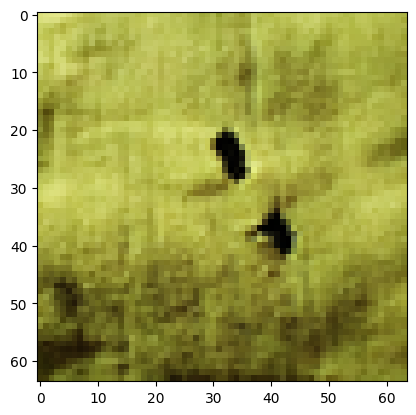

In [55]:
# Select a random anomaly image and check if it's reported as an anomaly
num_anomaly = random.randint(0, len(anomaly_file_paths) - 1)
anomaly_path = anomaly_file_paths[num_anomaly]
# anomaly_path='C:/Users/vansh/Desktop/BE project/crop_recon.png'
check_anomaly(anomaly_path)

UnimplementedError: Graph execution error:

Detected at node 'sequential/conv2d/Relu' defined at (most recent call last):
    File "c:\Users\Ananya Doshi\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Users\Ananya Doshi\AppData\Local\Programs\Python\Python310\lib\runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "C:\Users\Ananya Doshi\AppData\Roaming\Python\Python310\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "C:\Users\Ananya Doshi\AppData\Roaming\Python\Python310\site-packages\traitlets\config\application.py", line 1043, in launch_instance
      app.start()
    File "C:\Users\Ananya Doshi\AppData\Roaming\Python\Python310\site-packages\ipykernel\kernelapp.py", line 736, in start
      self.io_loop.start()
    File "C:\Users\Ananya Doshi\AppData\Roaming\Python\Python310\site-packages\tornado\platform\asyncio.py", line 195, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\Ananya Doshi\AppData\Local\Programs\Python\Python310\lib\asyncio\base_events.py", line 595, in run_forever
      self._run_once()
    File "c:\Users\Ananya Doshi\AppData\Local\Programs\Python\Python310\lib\asyncio\base_events.py", line 1881, in _run_once
      handle._run()
    File "c:\Users\Ananya Doshi\AppData\Local\Programs\Python\Python310\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\Ananya Doshi\AppData\Roaming\Python\Python310\site-packages\ipykernel\kernelbase.py", line 516, in dispatch_queue
      await self.process_one()
    File "C:\Users\Ananya Doshi\AppData\Roaming\Python\Python310\site-packages\ipykernel\kernelbase.py", line 505, in process_one
      await dispatch(*args)
    File "C:\Users\Ananya Doshi\AppData\Roaming\Python\Python310\site-packages\ipykernel\kernelbase.py", line 412, in dispatch_shell
      await result
    File "C:\Users\Ananya Doshi\AppData\Roaming\Python\Python310\site-packages\ipykernel\kernelbase.py", line 740, in execute_request
      reply_content = await reply_content
    File "C:\Users\Ananya Doshi\AppData\Roaming\Python\Python310\site-packages\ipykernel\ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "C:\Users\Ananya Doshi\AppData\Roaming\Python\Python310\site-packages\ipykernel\zmqshell.py", line 546, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\Ananya Doshi\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 3024, in run_cell
      result = self._run_cell(
    File "C:\Users\Ananya Doshi\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 3079, in _run_cell
      result = runner(coro)
    File "C:\Users\Ananya Doshi\AppData\Roaming\Python\Python310\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\Ananya Doshi\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 3284, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\Ananya Doshi\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 3466, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "C:\Users\Ananya Doshi\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py", line 3526, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\RProgramming\ipykernel_8416\2192800608.py", line 5, in <module>
      check_anomaly(anomaly_path)
    File "C:\RProgramming\ipykernel_8416\1901918945.py", line 63, in check_anomaly
      encoded_img = encoder.predict([[img_array]])
    File "c:\Users\Ananya Doshi\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Ananya Doshi\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py", line 2554, in predict
      tmp_batch_outputs = self.predict_function(iterator)
    File "c:\Users\Ananya Doshi\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py", line 2341, in predict_function
      return step_function(self, iterator)
    File "c:\Users\Ananya Doshi\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py", line 2327, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\Ananya Doshi\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py", line 2315, in run_step
      outputs = model.predict_step(data)
    File "c:\Users\Ananya Doshi\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py", line 2283, in predict_step
      return self(x, training=False)
    File "c:\Users\Ananya Doshi\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Ananya Doshi\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py", line 569, in __call__
      return super().__call__(*args, **kwargs)
    File "c:\Users\Ananya Doshi\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Ananya Doshi\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\base_layer.py", line 1150, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\Ananya Doshi\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Ananya Doshi\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\sequential.py", line 405, in call
      return super().call(inputs, training=training, mask=mask)
    File "c:\Users\Ananya Doshi\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\functional.py", line 512, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "c:\Users\Ananya Doshi\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\functional.py", line 669, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "c:\Users\Ananya Doshi\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Ananya Doshi\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\base_layer.py", line 1150, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\Ananya Doshi\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\Ananya Doshi\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py", line 321, in call
      return self.activation(outputs)
    File "c:\Users\Ananya Doshi\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\activations.py", line 321, in relu
      return backend.relu(
    File "c:\Users\Ananya Doshi\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\backend.py", line 5397, in relu
      x = tf.nn.relu(x)
Node: 'sequential/conv2d/Relu'
Fused conv implementation does not support grouped convolutions for now.
	 [[{{node sequential/conv2d/Relu}}]] [Op:__inference_predict_function_18422]

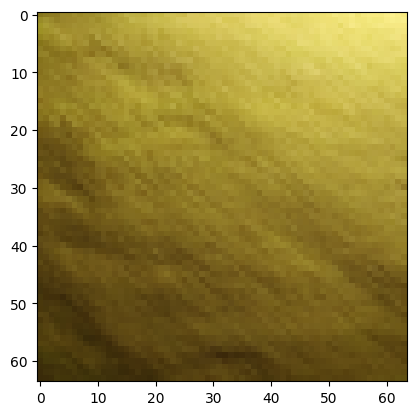

In [47]:
# Select a random non-defect (good) image and check if it's reported as an anomaly
num_uninfected = random.randint(0, len(uninfected_file_paths) - 1)
uninfected_path = uninfected_file_paths[num_uninfected]
# print(uninfected_path)
check_anomaly(uninfected_path)